In [2]:
# !pip install shap

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap 

import warnings
import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

In [4]:
#https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py
def oob_regression_r2_score(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) R^2 for a scikit-learn random forest
    regressor. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L702
    """
    X = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y = y_train.values if isinstance(y_train, pd.Series) else y_train

    n_samples = len(X)
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions

    oob_score = r2_score(y, predictions)
    return oob_score

#http://bakfu.github.io/doc/_modules/sklearn/ensemble/forest.html
from sklearn.utils import check_random_state #, check_array, compute_sample_weight
#from sklearn.utils.fixes import bincount

def generate_sample_indices(random_state, n_samples):
    """Private function used to _parallel_build_trees function."""
    random_instance = check_random_state(random_state)
    sample_indices = random_instance.randint(0, n_samples, n_samples)

    return sample_indices

def generate_unsampled_indices(random_state, n_samples):
    """Private function used to forest._set_oob_score fuction."""
    sample_indices = generate_sample_indices(random_state, n_samples)
    sample_counts = np.bincount(sample_indices, minlength=n_samples)
    unsampled_mask = sample_counts == 0
    indices_range = np.arange(n_samples)
    unsampled_indices = indices_range[unsampled_mask]

    return unsampled_indices

def shap_values_oob(X_train, rf):
    n_samples, p = X_train.shape
    k=0
    shap_oob = np.zeros((n_samples, p, rf.n_estimators))
    shap_inbag = np.zeros((n_samples, p, rf.n_estimators))
    for tree in rf.estimators_:
      tree_preds = tree.predict(X_train)
      unsampled_indices = generate_unsampled_indices(tree.random_state, n_samples)
      sampled_indices = generate_sample_indices(tree.random_state, n_samples)
      explainer = shap.TreeExplainer(tree)
      shap_oob[unsampled_indices,:,k] = explainer.shap_values(X_train.iloc[unsampled_indices,:])
      shap_inbag[sampled_indices,:,k] = explainer.shap_values(X_train.iloc[sampled_indices,:])
      #print(k)
      k+=1
    
    shap_oob_avg = np.sum(shap_oob, axis=2) 
    shap_inbag_avg = np.sum(shap_inbag, axis=2)
    globalSHAPImp_oob =np.sum(np.abs(shap_oob_avg), axis=0)
    globalSHAPImp_inbag = np.sum(np.abs(shap_inbag_avg), axis=0)
    return shap_oob,shap_inbag,shap_oob_avg,shap_inbag_avg,globalSHAPImp_oob,globalSHAPImp_inbag
    

In [22]:
def SimulateData_simple(n=120, # number of rows in data
                        M=100, # number of simulations
                        #nCores = M, # number of cores to use; set to 1 on Windows!
                        relevance = 0.15, # signal srength (0 for NULL)
                        inoutbag=False,
                        ntree = 100, #number of trees in forest
                        #correctBias = c(inbag=TRUE,outbag=TRUE),
                        verbose=0,
                        n_features = 3):
  
  random.seed(123)

  shap_avs = np.array([0,0,0,0,0]) # Initializes the first array
  shap_avs_oob = np.array([0,0,0,0,0]); shap_avs_in = np.array([0,0,0,0,0])
  ft_importances = np.array([0,0,0,0,0]) # Initializes the first array
  shap_vals = np.array([0,0,0,0,0]) # Initializes the first array
  shap_vals_oob = np.array([0,0,0,0,0]); shap_vals_in = np.array([0,0,0,0,0]) 
  allDFs = [] # List of DFs that will be filled
  y_train = []

  for i in range(M):

    x1 = np.random.randn(n)
    x2 = np.random.randint(1, 3, n)
    x3 = np.random.randint(1, 5, n)
    x4 = np.random.randint(1, 11, n)
    x5 = np.random.randint(1, 21, n)
    # y = np.random.binomial(n = 1, p = 0.5 + [-1,1][x2[0]-1] * relevance, size = n)
    y = np.array([]) 
    for i in range(n):
      y = np.append(y, np.random.binomial(n = 1, p = 0.5 + [-1,1][x2[i]-1] * relevance, size = 1))

    x_train = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5}, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
    # y_train = pd.DataFrame({'y': y}, columns=['y'])

    rf = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=ntree,max_features=n_features) 
    rf.fit(x_train, y)
    feature_importances = rf.feature_importances_
    # print(feature_importances)
    ft_importances = np.vstack((ft_importances, feature_importances))
    allDFs.append(x_train)
    y_train.append(y)
    
    warnings.filterwarnings('ignore')
    if (inoutbag):
        shap_oob,shap_inbag,shap_oob_avg,shap_inbag_avg,globalSHAPImp_oob,globalSHAPImp_inbag = shap_values_oob(x_train, rf)
        shap_vals_oob = np.vstack((shap_vals_oob, shap_oob_avg))
        shap_vals_in = np.vstack((shap_vals_in, shap_inbag_avg))
        shap_avs_oob = np.vstack((shap_avs_oob, globalSHAPImp_oob))
        shap_avs_in = np.vstack((shap_avs_in, globalSHAPImp_inbag))
        #return(shap_oob,shap_inbag,shap_oob_avg,shap_inbag_avg,globalSHAPImp_oob,globalSHAPImp_inbag, rlvFtrs)
    else:    
        shap_values = shap.TreeExplainer(rf).shap_values(x_train)
        shap_averages = np.sum(np.absolute(shap_values), axis=0)

        shap_vals = np.vstack((shap_vals, shap_values))
        shap_avs = np.vstack((shap_avs, shap_averages))
  
  ft_importances = np.delete(ft_importances, (0), axis=0) # Deletes the initialization

  if (inoutbag):
      shap_vals_oob = np.delete(shap_vals_oob, (0), axis=0) # Deletes the initialization
      shap_vals_in = np.delete(shap_vals_in, (0), axis=0)
      shap_avs_oob = np.delete(shap_avs_oob, (0), axis=0) # Deletes the initialization
      shap_avs_in = np.delete(shap_avs_in, (0), axis=0)
      return(shap_vals_oob,shap_vals_in,shap_avs_oob, shap_avs_in, ft_importances, allDFs, n, y_train)
  else: 
      shap_vals = np.delete(shap_vals, (0), axis=0) # Deletes the initialization
      shap_avs = np.delete(shap_avs, (0), axis=0) # Deletes the initialization
      return(shap_vals, shap_avs, ft_importances, allDFs, n)


In [6]:
def beeswarm(simulation, n):
  shap.summary_plot(shap_vals[0+n*simulation:n+n*simulation], allDFs[simulation], show=True)

In [31]:
print(datetime.datetime.now())
start_time = time.time()

shap_vals_oob,shap_vals_in,shap_avs_oob, shap_avs_in, ft_importances, allDFs, n, y_train = SimulateData_simple(n=120, M=100, inoutbag = True)

print("--- %s seconds ---" , (time.time() - start_time))
y_train = np.concatenate(y_train)

2020-05-19 07:31:30.932309
--- %s seconds --- 54.46132135391235


In [32]:
print(shap_vals_oob.shape,shap_avs_oob.shape, y_train.shape)

(12000, 5) (100, 5) (12000,)


In [ ]:
shap_oob_all_wghted = (shap_vals_oob.T*y_train).T
shap_inbag_all_wghted = (shap_inbag_all.T*y_train).T

print(shap_inbag_all_wghted.shape,shap_oob_all_wghted.shape)

In [25]:
shap_vals_oob.tofile("data/shap_vals_oob_sim1_power.tsv","\t")
shap_vals_in.tofile("data/shap_vals_in_sim1_power.tsv","\t")
y_train.tofile("data/y_train_sim1_power.tsv","\t")

shap_avs_oob.tofile("shap_avs_sim1_oob_power.tsv","\t")
shap_avs_in.tofile("shap_avs_sim1_inbag_power.tsv","\t")

print(shap_vals_oob.shape, shap_vals_in.shape, y_train.shape)

(12000, 5) (12000, 5) (12000,)


Text(0.5, 1.0, 'Inbag')

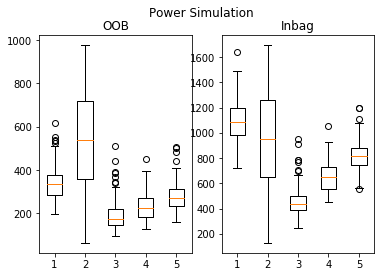

In [16]:
#plt.boxplot(shap_avs_oob);
#plt.boxplot(shap_avs_in);
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Power Simulation')
ax1.boxplot(shap_avs_oob);ax1.set_title('OOB')
ax2.boxplot(shap_avs_in);ax2.set_title('Inbag')

In [24]:
print(np.concatenate(y_train).shape)

(12000,)


In [5]:
start_time = time.time()

shap_vals, shap_avs, ft_importances, allDFs, n = SimulateData_simple(n=120, M=100)

print("--- %s seconds ---" % (time.time() - start_time))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.

--- 18.279312133789062 seconds ---


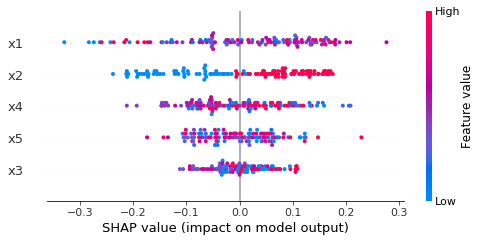

In [6]:
beeswarm(0, n) # plots the M-th simulation 

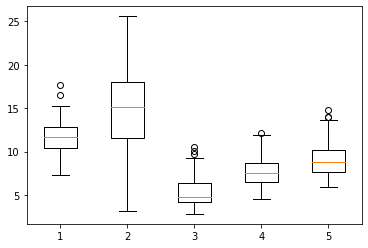

In [7]:
plt.boxplot(shap_avs);

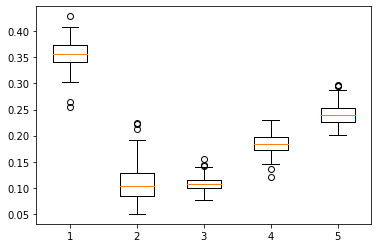

In [8]:
plt.boxplot(ft_importances);

In [11]:
type(shap_avs)

numpy.ndarray

In [19]:
shap_avs.tofile("shap_avs_sim1_power.tsv","\t")

#### NULL simulation


In [15]:
start_time = time.time()

shap_vals0, shap_avs0, ft_importances0, allDFs0, n0 = SimulateData_simple(n=120, M=100, relevance=0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 18.82581615447998 seconds ---


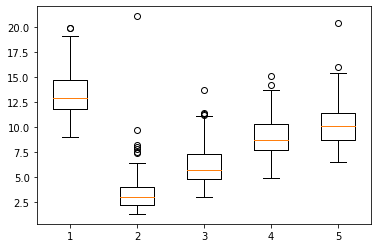

In [16]:
plt.boxplot(shap_avs0);

In [27]:
start_time = time.time()
print(datetime.datetime.now())
shap_vals_oob0,shap_vals_in0,shap_avs_oob0, shap_avs_in0, ft_importances0, allDFs0, n0, y_train0 = SimulateData_simple(n=120, M=100, relevance=0, inoutbag = True)

print("--- %s seconds ---" , (time.time() - start_time))
print(shap_avs_oob0.shape)

y_train0 = np.concatenate(y_train0)


1589717234.8516526
--- %s seconds --- 55.749228715896606
(100, 5)


In [28]:
shap_vals_oob0.tofile("data/shap_vals_oob_sim1_null.tsv","\t")
shap_vals_in0.tofile("data/shap_vals_in_sim1_null.tsv","\t")
y_train0.tofile("data/y_train_sim1_null.tsv","\t")

shap_avs_oob0.tofile("shap_avs_sim1_oob_null.tsv","\t")
shap_avs_in0.tofile("shap_avs_sim1_inbag_null.tsv","\t")

print(shap_vals_oob.shape, shap_vals_in.shape, y_train.shape)
import datetime
print(datetime.datetime.now())
#shap_avs0.tofile("shap_avs_sim1_null.tsv","\t")

(12000, 5) (12000, 5) (12000,)


1589717305.1352289

Text(0.5, 1.0, 'Inbag')

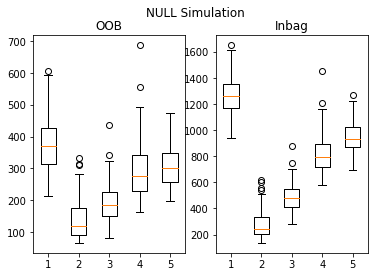

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('NULL Simulation')
ax1.boxplot(shap_avs_oob0);ax1.set_title('OOB')
ax2.boxplot(shap_avs_in0);ax2.set_title('Inbag')

In [21]:
shap_avs_oob0.tofile("shap_avs_sim1_oob_null.tsv","\t")
shap_avs_in0.tofile("shap_avs_sim1_inbag_null.tsv","\t")

In [29]:
import datetime
print(datetime.datetime.now())

2020-05-17 12:11:37.926191


In [30]:
!tar chvfz SHAPsimData.tar.gz data/*

data/rlvFtrs_all.tsv
data/shap_inbag_all.tsv
data/shap_oob_all.tsv
data/shap_vals_in_sim1_null.tsv
data/shap_vals_in_sim1_power.tsv
data/shap_vals_oob_sim1_null.tsv
data/shap_vals_oob_sim1_power.tsv
data/y_train_all.tsv
data/y_train_sim1_null.tsv
data/y_train_sim1_power.tsv
